In [1]:
from pathlib import Path
import sys
import os
SPIKECOUNTER_PATH = os.getenv("SPIKECOUNTER_PATH")
sys.path.append(SPIKECOUNTER_PATH)

import matplotlib.pyplot as plt
from matplotlib import patches, lines
import matplotlib as mpl
import matplotlib.cm as cmaps
import matplotlib.colors as colors
from matplotlib import gridspec
import colorcet as cc

from scipy import interpolate, signal, stats, optimize, ndimage
import scipy.io as scio
import numpy as np
import os
import skimage.io as skio
from skimage import measure, draw, transform, exposure

import pickle
import seaborn as sbs
from parse import *
import seaborn as sns

from spikecounter.analysis import traces, images
from spikecounter import utils
from spikecounter.ui import visualize, HyperStackViewer
from spikecounter.analysis import stats as sc_stats
from sklearn import neighbors
import lmfit
from cycler import cycler
import pandas as pd
import importlib
from statannotations.Annotator import Annotator
pubstyle_path = os.path.join(os.getenv("SPIKECOUNTER_PATH"), "config", "bio_publications.mplstyle")
plt.style.use(
    pubstyle_path
)

In [2]:
output_datadir = Path(os.getenv("ANALYSIS_OUTPUT_ROOTDIR"), "2022 First Heartbeat_Submitted/Figures/Data/Figure5")
um_per_px = 0.265*4

In [24]:
waveprop_data = pd.read_csv(output_datadir/"wave_propagation_filtered.csv")
if "Unnamed: 0" in waveprop_data:
    del waveprop_data["Unnamed: 0"]

In [25]:
pop_quartiles = pd.read_csv(output_datadir.parent/"Figure1"/"population_frequency.csv")

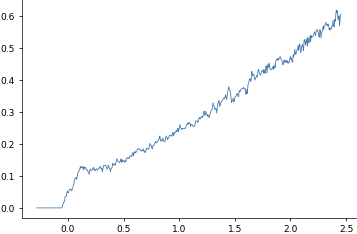

In [26]:
plt.plot(pop_quartiles["time_post_offset_h"], pop_quartiles["p50"])

In [27]:
pop_quartiles["time_post_offset_h"] = pop_quartiles["time_post_offset_h"] - pop_quartiles["time_post_offset_h"].iloc[np.argwhere(pop_quartiles["p50"].to_numpy()>0).ravel()[0]]

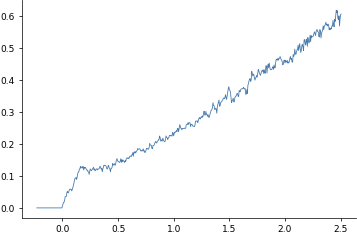

In [28]:
plt.plot(pop_quartiles["time_post_offset_h"], pop_quartiles["p50"])

In [29]:
np.argwhere(pop_quartiles["time_post_offset_h"].to_numpy()>0).ravel()[0]

541

In [30]:
waveprop_by_embryo = waveprop_data.set_index(["expt_name", "embryo"])
waveprop_by_embryo["est_tpo_h"] = np.nan
waveprop_by_embryo["roi_nkx_intensity"] = np.nan
waveprop_by_embryo["rand_nkx_intensity"] = np.nan
waveprop_by_embryo["rand_nkx_intensity_single_shot"] = np.nan

In [31]:
remote_data_rootdir = Path("/n/cohen_lab/Lab/Labmembers/Bill Jia/Data/")

/tmp/ipykernel_251790/3758984347.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  embryo_data = waveprop_by_embryo.loc[idx].sort_values(["rel_offset_h"])
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


('/n/holyscratch01/cohen_lab/bjia/20220505_25x_gcamp_focus', 2) nan


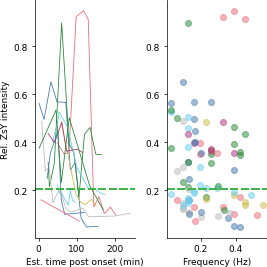

In [32]:
updated_dfs = []
radius = 5
fig1, axes = plt.subplots(1,2, figsize=(4,4))
n_rand_reps = 100
nkx_raw = {}
nkx_normalized = {}
for idx in waveprop_by_embryo.index.unique():
    embryo_data = waveprop_by_embryo.loc[idx].sort_values(["rel_offset_h"])
#     if idx[0] == '/n/holyscratch01/cohen_lab/bjia/20230308_TCF_nlsmCh_nkx2.5_LOI':
#         print(embryo_data)
#         break
    first_time = pop_quartiles["time_post_offset_h"].iloc[np.nanargmin((pop_quartiles["p50"]-embryo_data["freq"].iloc[0])**2)]
    xs = []
    xs2 = []
    ys = []
    for i in range(embryo_data.shape[0]):
        row = embryo_data.iloc[i]
        try:
            snap_path = remote_data_rootdir/"BU"/os.path.basename(idx[0])/"Snaps"/row["snap_file"]
        except Exception as e:
            print(idx, row["snap_file"])
#             raise e
            continue
        nkx = skio.imread(snap_path)
        nkx = transform.downscale_local_mean(nkx, (4,4))
        diff = (nkx.shape[0] - row["image_width"])//2
        if diff > 0:
            nkx = nkx[diff:-diff, diff:-diff]
        mask = np.zeros_like(nkx, dtype=bool)
        
        patch = draw.disk((row["loi_y"], row["loi_x"]), radius, shape=mask.shape)
        nkx_raw[row["file_name"]] = np.copy(nkx)
        cap = np.percentile(nkx, 99)
        nkx[nkx > cap] = cap
        nkx -= 100
        mask[patch] = True
        nkx = (nkx - np.min(nkx))/(cap-np.min(nkx))
        nkx_normalized[row["file_name"]] = np.copy(nkx)
        max_nkx_intensity = 1
        loi_intensity = np.mean(nkx[mask])
        time = row["rel_offset_h"] + first_time
        embryo_data["est_tpo_h"].iloc[i] = time
        embryo_data["roi_nkx_intensity"].iloc[i] = loi_intensity/max_nkx_intensity
        
        rand_intensities = []
        for j in range(n_rand_reps):
            mask = np.zeros_like(nkx, dtype=bool)
            patch = draw.disk((np.random.choice(np.arange(radius, mask.shape[0]-radius)), 
                               np.random.choice(np.arange(radius, mask.shape[1]-radius))), radius, shape=mask.shape)
            mask[patch] = True
            rand_intensities.append(np.mean(nkx[mask]))
        embryo_data["rand_nkx_intensity"].iloc[i] = np.mean(rand_intensities)/max_nkx_intensity
        embryo_data["rand_nkx_intensity_single_shot"].iloc[i] = rand_intensities[0]/max_nkx_intensity
        xs.append(time*60)
        xs2.append(row["freq"])
        ys.append(loi_intensity/max_nkx_intensity)
#         print(loi_intensity, max_nkx_intensity, loi_intensity/max_nkx_intensity)
    axes[0].plot(xs, ys)
    axes[1].scatter(xs2, ys, alpha= 0.5)
    axes[0].set_ylabel("Rel. ZsY intensity")
    axes[0].set_xlabel("Est. time post onset (min)")
    axes[1].set_xlabel("Frequency (Hz)")
    axes[0].axhline(y=0.2044, color="#40B449", linestyle="--", linewidth=2)
    axes[1].axhline(y=0.2044, color="#40B449", linestyle="--", linewidth=2)
    updated_dfs.append(embryo_data)
plt.tight_layout()
# plt.savefig(os.path.join(data_folder, "loi_nkx_intensity_progression.svg"))

In [23]:
item_list = list(nkx_raw.items())
interior_masks = np.load(output_datadir/"inner_edge_masks.npz", allow_pickle=True)["interior_masks"][()]
# interior_masks = {}

124554E3_fast
(216, 216)
[0 1 2]


<IPython.core.display.Javascript object>


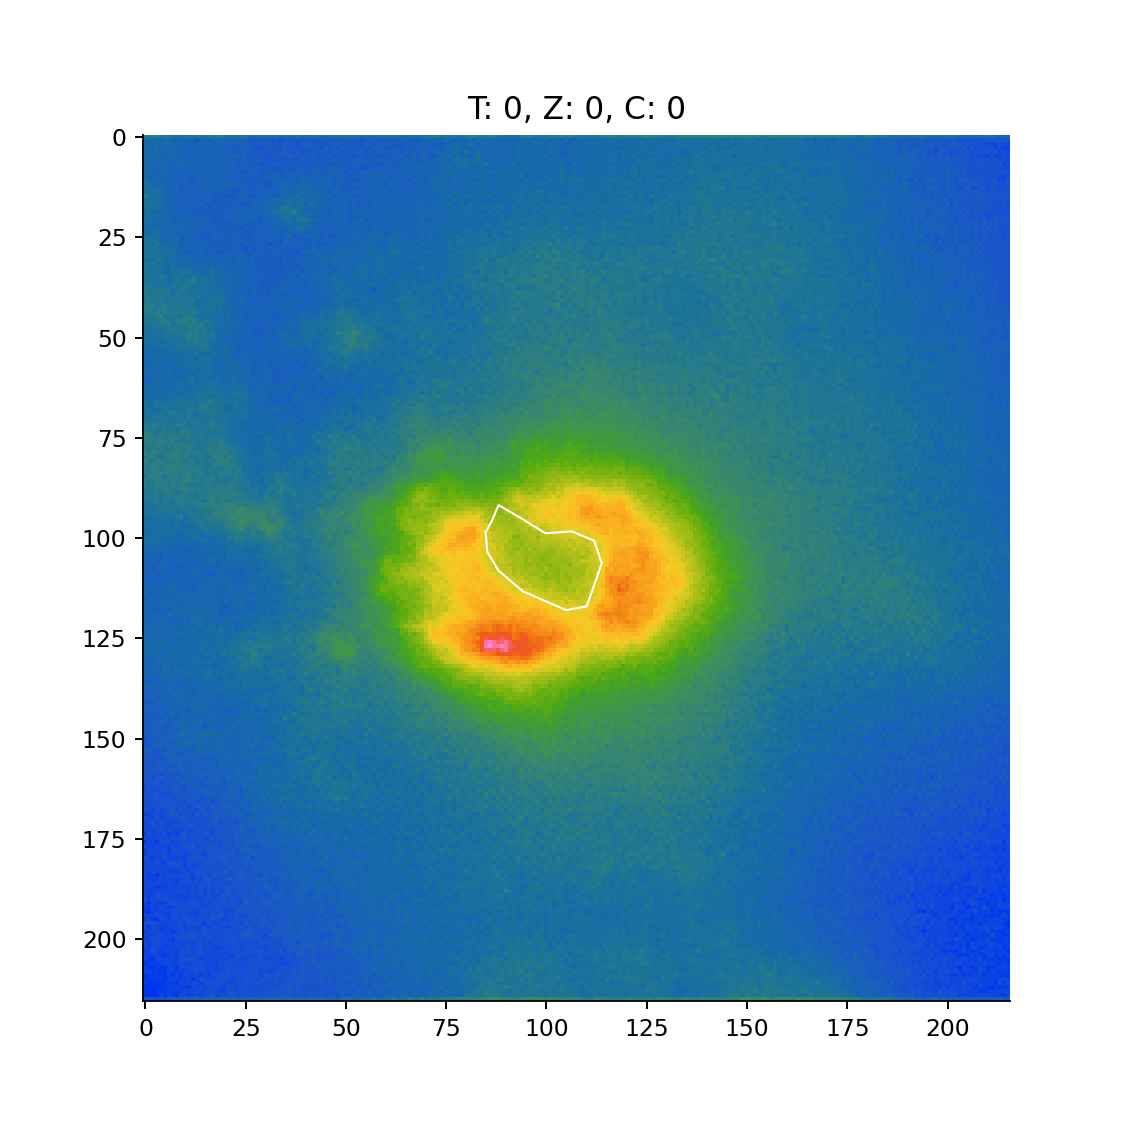

This happened


In [168]:
%matplotlib notebook
i = 88
fname, img = item_list[i]
print(fname)
h = HyperStackViewer(img, width=6, height=6)
h.select_region_clicky()
# interior_masks[fname] = mask

In [169]:
mask = h._points_to_mask(h.points)
interior_masks[fname] = np.copy(mask)
np.savez(output_datadir/"inner_edge_masks.npz", interior_masks=interior_masks)

In [60]:
waveprop_updated = pd.concat(updated_dfs)

In [61]:
waveprop_updated.reset_index().to_csv(output_datadir/"wave_propagation_filtered_nkx_intensities.csv", index=False)

In [5]:
waveprop_updated = pd.read_csv(output_datadir/"wave_propagation_filtered_nkx_intensities.csv").set_index(["expt_name", "embryo"])
interior_masks = np.load(output_datadir/"inner_edge_masks.npz", allow_pickle=True)["interior_masks"][()]

In [6]:
waveprop_updated["diff_15"] = np.abs(waveprop_updated["est_tpo_h"] - 0.25)
waveprop_updated["diff_105"] = np.abs(waveprop_updated["est_tpo_h"] - 1.75)

In [7]:
boxplot_df = waveprop_updated[["file_name", "diff_15", "diff_105", "est_tpo_h", "distance_to_cone",
                "roi_nkx_intensity", "rand_nkx_intensity", "rand_nkx_intensity_single_shot", "freq"]]

In [8]:
unique_indices = boxplot_df.index.unique()
for idx in unique_indices:
    print(np.min(boxplot_df.loc[idx]["diff_15"]))

0.012434640522880402
0.5637254901959281
0.1666666666665897
0.7254901960782512
0.3627450980391025
0.1666666666665897
0.045130718954223714
0.12254901960777431
0.1519607843137436
0.2254901960784359
nan
0.5637254901959281


/tmp/ipykernel_801861/1457120507.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  print(np.min(boxplot_df.loc[idx]["diff_15"]))


In [9]:
early_tpoint = boxplot_df.sort_values("diff_15").reset_index().groupby(["expt_name", "embryo"]).nth(0).dropna().reset_index()
late_tpoint = boxplot_df.sort_values("diff_105").reset_index().groupby(["expt_name", "embryo"]).nth(0).dropna().reset_index()

In [10]:
early_tpoint["tpoint"] = "15"
late_tpoint["tpoint"] = "105"

In [11]:
boxplot_combined = pd.concat([early_tpoint, late_tpoint]).drop(index=[2])

In [12]:
loi_measurements = boxplot_combined[['expt_name', 'file_name', 'embryo', 'diff_15', 'diff_105', 'est_tpo_h',
       'distance_to_cone', 'roi_nkx_intensity',
       'tpoint']].rename(columns={"roi_nkx_intensity": "rel_nkx_intensity"})
loi_measurements["cond"] = "LOI"
rand_measurements = boxplot_combined[['expt_name', 'file_name', 'embryo', 'diff_15', 'diff_105', 'est_tpo_h',
       'distance_to_cone', 'rand_nkx_intensity',
       'tpoint']].rename(columns={"rand_nkx_intensity": "rel_nkx_intensity"})
rand_measurements["cond"] = "Rand."
loi_vs_rand = pd.concat([rand_measurements, loi_measurements])

In [13]:
loi_time = loi_vs_rand.set_index(["cond"]).loc["LOI"].sort_values(["expt_name", "embryo","est_tpo_h"])
loi_time_by_embryo = loi_time.set_index(["expt_name", "embryo"])


In [14]:
%matplotlib inline
strip_width = 5
loi_dist_nkx_intensities = []
for idx in loi_time_by_embryo.index.unique():
    dist = loi_time_by_embryo.loc[idx, "distance_to_cone"].iloc[0]
    print(dist)
    for j in range(2):
        fname = loi_time_by_embryo.loc[idx, "file_name"].iloc[j]
        mask = np.squeeze(interior_masks[fname])
        inner_edge_dist_map = ndimage.distance_transform_edt(~mask, sampling=um_per_px)
        strip_mask = (inner_edge_dist_map > dist - strip_width/2)*(inner_edge_dist_map < dist + strip_width/2)
        nkx_img = nkx_normalized[fname]
        loi_dist_nkx_intensities.append(np.nanmean(nkx_img[strip_mask]))
        print(loi_dist_nkx_intensities[-1], loi_time_by_embryo.loc[idx, "rel_nkx_intensity"].iloc[j])
loi_time["original_loi_rel_nkx"] = loi_dist_nkx_intensities

24.87681054852506


NameError: name 'nkx_normalized' is not defined

In [43]:
output_datadir

PosixPath('/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure5')

In [46]:
loi_time.to_csv(output_datadir/"time_paired_LOIs.csv")

In [24]:
loi_time = pd.read_csv(output_datadir/"time_paired_LOIs.csv")
loi_time["tpoint"] = loi_time["tpoint"].astype('string')

ShapiroResult(statistic=0.9455140829086304, pvalue=0.6158264875411987)
ShapiroResult(statistic=0.9583739638328552, pvalue=0.7671840190887451)
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

15 vs. 105: Wilcoxon test (paired samples), P_val:3.223e-01 Stat=1.700e+01


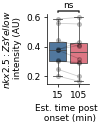

In [32]:
x = "tpoint"
y= "original_loi_rel_nkx"
hue = "tpoint"
order = ["15", "105"]
df = loi_time

with plt.style.context(pubstyle_path):
    fig1, ax1 = plt.subplots(figsize=(1.5,2))
    sns.boxplot(data=df, x=x, y=y, order=order, fliersize=0)
    ax1.set_xlabel("Est. time post \n onset (min)")
    ax1.set_ylabel("$\it{nkx2.5:ZsYellow}$ \n intensity (AU)")
    grouped_data = df.set_index(x)
    indices = grouped_data.index.unique()
    for i, idx in enumerate(indices):
        print(stats.shapiro(grouped_data.loc[idx,y]))
        ax1.scatter(i*np.ones(grouped_data.loc[idx].shape[0]), grouped_data.loc[idx,y],
                alpha=0.2, color="k", s=16)
    ax1.plot(np.array([0*np.ones(grouped_data.loc[indices[0]].shape[0]), 
                       1*np.ones(grouped_data.loc[indices[0]].shape[0])]),
             np.array([grouped_data.loc[indices[0], y],
                      grouped_data.loc[indices[1], y]]), color="k", alpha=0.2)
    pairs = [tuple(order)]
    annot = Annotator(ax1, pairs, data=df, x=x,y=y)
    annot.configure(test="Wilcoxon", verbose=2, loc="outside")
    annot.apply_and_annotate()
    plt.tight_layout()
    plt.savefig(output_datadir/"nkx_intensity_original_LOI_time.svg", dpi=300, bbox_inches="tight")

ShapiroResult(statistic=0.9567456245422363, pvalue=0.7482240796089172)
ShapiroResult(statistic=0.8363361358642578, pvalue=0.03987807407975197)
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

15 vs. 105: Wilcoxon test (paired samples), P_val:1.953e-02 Stat=5.000e+00


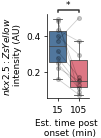

In [35]:
x = "tpoint"
y= "rel_nkx_intensity"
hue = "tpoint"
order = ["15", "105"]
df = loi_time

with plt.style.context(pubstyle_path):
    fig1, ax1 = plt.subplots(figsize=(1.5,2.2))
    sns.boxplot(data=df, x=x, y=y, order=order, fliersize=0)
    ax1.set_xlabel("Est. time post \n onset (min)")
    ax1.set_ylabel("$\it{nkx2.5:ZsYellow}$ \n intensity (AU)")
    grouped_data = df.set_index(x)
    indices = grouped_data.index.unique()
    for i, idx in enumerate(indices):
        print(stats.shapiro(grouped_data.loc[idx,y]))
        ax1.scatter(i*np.ones(grouped_data.loc[idx].shape[0]), grouped_data.loc[idx,y],
                alpha=0.2, color="k", s=16)
    ax1.plot(np.array([0*np.ones(grouped_data.loc[indices[0]].shape[0]), 
                       1*np.ones(grouped_data.loc[indices[0]].shape[0])]),
             np.array([grouped_data.loc[indices[0], y],
                      grouped_data.loc[indices[1], y]]), color="k", alpha=0.2)
    pairs = [tuple(order)]
    annot = Annotator(ax1, pairs, data=df, x=x,y=y)
    annot.configure(test="Wilcoxon", verbose=2, loc="outside")
    annot.apply_and_annotate()
    plt.tight_layout()
    plt.savefig(output_datadir/"nkx_intensity_LOI.svg", dpi=300, bbox_inches="tight")

/tmp/ipykernel_193629/1245954568.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax1.scatter(-0.2*np.ones(grouped_data.loc[(idx_o,index_inner[0])].shape[0]) + i,
/tmp/ipykernel_193629/1245954568.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  grouped_data.loc[(idx_o,index_inner[0])][y],
/tmp/ipykernel_193629/1245954568.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax1.scatter(0.2*np.ones(grouped_data.loc[(idx_o,index_inner[1])].shape[0]) + i,
/tmp/ipykernel_193629/1245954568.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  grouped_data.loc[(idx_o,index_inner[1])][y],
/tmp/ipykernel_193629/1245954568.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax1.plot(np.array([-0.2*np.ones(grouped_data.loc[(idx_o,index_inner[0])].shape[0]) + 0,
/tmp/ipykernel_193629/1245954568.py:24: PerformanceWarning: indexing past lexsort depth may

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

LOI_15 vs. LOI_105: Wilcoxon test (paired samples), P_val:1.953e-02 Stat=5.000e+00
Rand._15 vs. Rand._105: Wilcoxon test (paired samples), P_val:3.750e-01 Stat=1.800e+01
Rand._15 vs. LOI_15: Wilcoxon test (paired samples), P_val:5.859e-03 Stat=2.000e+00
Rand._105 vs. LOI_105: Wilcoxon test (paired samples), P_val:1.309e-01 Stat=1.200e+01


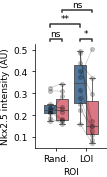

In [71]:
x = "cond"
y= "rel_nkx_intensity"
hue = "tpoint"
order = ["Rand.", "LOI"]
hue_order = ["15", "105"]
df = loi_vs_rand

with plt.style.context(pubstyle_path):
    fig1, ax1 = plt.subplots(figsize=(1.75,3))
    sns.boxplot(data=df, x=x, y=y, hue=hue, fliersize=0, hue_order=hue_order, order=order)
    ax1.set_xlabel("ROI")
    ax1.set_ylabel("Nkx2.5 intensity (AU)")
grouped_data = df.set_index([x, hue])
index_outer = grouped_data.index.unique(x)
index_inner = grouped_data.index.unique(hue)
for i, idx_o in enumerate(index_outer):
    ax1.scatter(-0.2*np.ones(grouped_data.loc[(idx_o,index_inner[0])].shape[0]) + i, 
                grouped_data.loc[(idx_o,index_inner[0])][y],
                alpha=0.2, color="k", s=16)
    ax1.scatter(0.2*np.ones(grouped_data.loc[(idx_o,index_inner[1])].shape[0]) + i, 
                grouped_data.loc[(idx_o,index_inner[1])][y],
                alpha=0.2, color="k", s=16)
    ax1.plot(np.array([-0.2*np.ones(grouped_data.loc[(idx_o,index_inner[0])].shape[0]) + 0, 
                       0.2*np.ones(grouped_data.loc[(idx_o,index_inner[1])].shape[0])]) + i,
        np.array([grouped_data.loc[(idx_o,index_inner[0])][y].values,  grouped_data.loc[(idx_o,index_inner[1])][y].values]),
        color="k", alpha=0.2)
ax1.get_legend().remove()
pairs = [[("Rand.", "15"), ("Rand.", "105")], [("LOI", "15"), ("LOI", "105")], [("Rand.", "15"), ("LOI", "15")],
        [("Rand.", "105"), ("LOI", "105")]]
annot = Annotator(ax1, pairs, data=df, x=x,y=y, hue=hue, hue_order=hue_order, comparisons_correction="fdr_bh")
annot.configure(test="Wilcoxon", verbose=2, loc="outside")
annot.apply_and_annotate()
plt.tight_layout()
fig1.savefig(output_datadir/"nkx2.5_intensity_comparison.svg", dpi=300, bbox_inches="tight")

In [72]:
loi_measurements = boxplot_combined[['expt_name', 'embryo', 'diff_15', 'diff_105', 'est_tpo_h',
       'distance_to_cone', 'roi_nkx_intensity',
       'tpoint']].rename(columns={"roi_nkx_intensity": "rel_nkx_intensity"})
loi_measurements["cond"] = "LOI"
rand_measurements = boxplot_combined[['expt_name', 'embryo', 'diff_15', 'diff_105', 'est_tpo_h',
       'distance_to_cone', 'rand_nkx_intensity_single_shot',
       'tpoint']].rename(columns={"rand_nkx_intensity_single_shot": "rel_nkx_intensity"})
rand_measurements["cond"] = "Rand."
loi_vs_rand = pd.concat([rand_measurements, loi_measurements])

/tmp/ipykernel_193629/1819351588.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax1.scatter(-0.2*np.ones(grouped_data.loc[(idx_o,index_inner[0])].shape[0]) + i,
/tmp/ipykernel_193629/1819351588.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  grouped_data.loc[(idx_o,index_inner[0])][y],
/tmp/ipykernel_193629/1819351588.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax1.scatter(0.2*np.ones(grouped_data.loc[(idx_o,index_inner[1])].shape[0]) + i,
/tmp/ipykernel_193629/1819351588.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  grouped_data.loc[(idx_o,index_inner[1])][y],
/tmp/ipykernel_193629/1819351588.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax1.plot(np.array([-0.2*np.ones(grouped_data.loc[(idx_o,index_inner[0])].shape[0]) + 0,
/tmp/ipykernel_193629/1819351588.py:23: PerformanceWarning: indexing past lexsort depth may

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

LOI_15 vs. LOI_105: Wilcoxon test (paired samples), P_val:1.953e-02 Stat=5.000e+00
Rand._15 vs. Rand._105: Wilcoxon test (paired samples), P_val:4.316e-01 Stat=1.900e+01
Rand._15 vs. LOI_15: Wilcoxon test (paired samples), P_val:2.324e-01 Stat=1.500e+01
Rand._105 vs. LOI_105: Wilcoxon test (paired samples), P_val:7.695e-01 Stat=2.400e+01


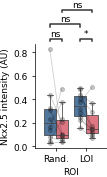

In [73]:
y= "rel_nkx_intensity"
hue = "tpoint"
order = ["Rand.", "LOI"]
hue_order = ["15", "105"]
df = loi_vs_rand

with plt.style.context(pubstyle_path):
    fig1, ax1 = plt.subplots(figsize=(1.75,3))
    sns.boxplot(data=df, x=x, y=y, hue=hue, fliersize=0, hue_order=hue_order, order=order)
    ax1.set_xlabel("ROI")
    ax1.set_ylabel("Nkx2.5 intensity (AU)")
grouped_data = df.set_index([x, hue])
index_outer = grouped_data.index.unique(x)
index_inner = grouped_data.index.unique(hue)
for i, idx_o in enumerate(index_outer):
    ax1.scatter(-0.2*np.ones(grouped_data.loc[(idx_o,index_inner[0])].shape[0]) + i, 
                grouped_data.loc[(idx_o,index_inner[0])][y],
                alpha=0.2, color="k", s=16)
    ax1.scatter(0.2*np.ones(grouped_data.loc[(idx_o,index_inner[1])].shape[0]) + i, 
                grouped_data.loc[(idx_o,index_inner[1])][y],
                alpha=0.2, color="k", s=16)
    ax1.plot(np.array([-0.2*np.ones(grouped_data.loc[(idx_o,index_inner[0])].shape[0]) + 0, 
                       0.2*np.ones(grouped_data.loc[(idx_o,index_inner[1])].shape[0])]) + i,
        np.array([grouped_data.loc[(idx_o,index_inner[0])][y].values,  grouped_data.loc[(idx_o,index_inner[1])][y].values]),
        color="k", alpha=0.2)
ax1.get_legend().remove()
pairs = [[("Rand.", "15"), ("Rand.", "105")], [("LOI", "15"), ("LOI", "105")], [("Rand.", "15"), ("LOI", "15")],
        [("Rand.", "105"), ("LOI", "105")]]
annot = Annotator(ax1, pairs, data=df, x=x,y=y, hue=hue, hue_order=hue_order, comparisons_correction="fdr_bh")
annot.configure(test="Wilcoxon", verbose=2, loc="outside")
annot.apply_and_annotate()
plt.tight_layout()

In [324]:
for idx in grouped_data.index.unique():
    print(stats.shapiro(grouped_data.loc[idx, "rel_nkx_intensity"]))

ShapiroResult(statistic=0.8733715415000916, pvalue=0.10941170901060104)
ShapiroResult(statistic=0.9222636222839355, pvalue=0.376222163438797)
ShapiroResult(statistic=0.9567456245422363, pvalue=0.7482240796089172)
ShapiroResult(statistic=0.8363361358642578, pvalue=0.03987807407975197)


/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [313]:
3/1.75*1.3

2.2285714285714286

In [319]:
print(stats.shapiro(grouped_data.loc["15"]["distance_to_cone"]))
print(stats.shapiro(grouped_data.loc["105"]["distance_to_cone"]))

ShapiroResult(statistic=0.8724638819694519, pvalue=0.10678873211145401)
ShapiroResult(statistic=0.892342209815979, pvalue=0.18016691505908966)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

15 vs. 105: t-test paired samples, P_val:1.381e-03 t=-4.552e+00


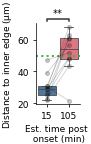

In [37]:
x = "tpoint"
y= "distance_to_cone"
order = ["15", "105"]
df = boxplot_combined

with plt.style.context(pubstyle_path):
    fig1, ax1 = plt.subplots(figsize=(1.4,2.2))
    sns.boxplot(data=df, x=x, y=y, fliersize=0, order=order)
    ax1.axhline(50, linestyle="dotted", linewidth=2, color="#40B449")
    ax1.set_xlabel("Est. time post \n onset (min)")
    ax1.set_ylabel(r"Distance to inner edge ($\mathrm{\mu m}$)")
    grouped_data = df.set_index(x)
    indices = grouped_data.index.unique()
    for i, idx in enumerate(indices):
        ax1.scatter(i*np.ones(grouped_data.loc[idx].shape[0]), grouped_data.loc[idx,y],
                alpha=0.2, color="k", s=16)
    ax1.plot(np.array([0*np.ones(grouped_data.loc[indices[0]].shape[0]), 
                       1*np.ones(grouped_data.loc[indices[0]].shape[0])]),
             np.array([grouped_data.loc[indices[0], y],
                      grouped_data.loc[indices[1], y]]), color="k", alpha=0.2)
pairs = [tuple(order)]
annot = Annotator(ax1, pairs, data=df, x=x,y=y)
annot.configure(test="t-test_paired", verbose=2, loc="outside")
annot.apply_and_annotate()
plt.tight_layout()
fig1.savefig(output_datadir/"loi_cone_distance.svg", dpi=300, bbox_inches="tight")

Characterize nkx intensity vs spike amplitude

In [6]:
waveprop_data = pd.read_csv(output_datadir/"wave_propagation_filtered_nkx_intensities.csv")

/tmp/ipykernel_51805/2867779529.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, axs = plt.subplots(1,2, figsize=(6,3))


81 nan


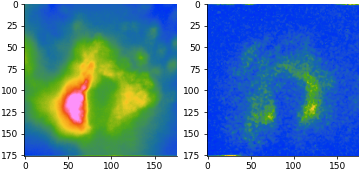

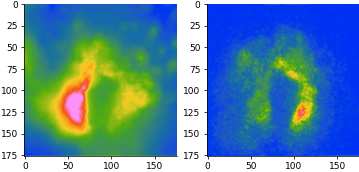

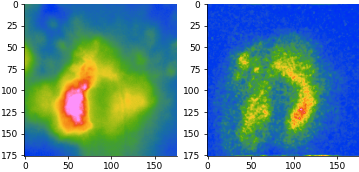

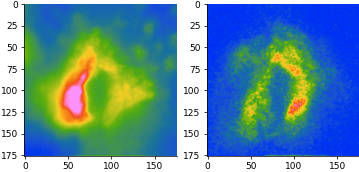

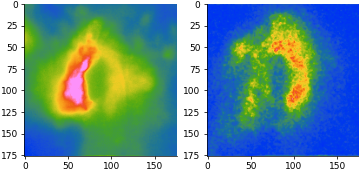

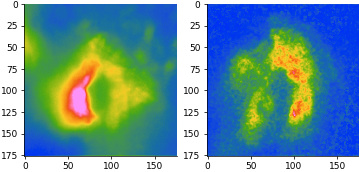

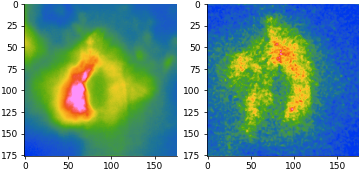

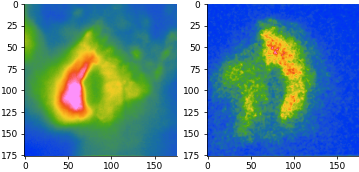

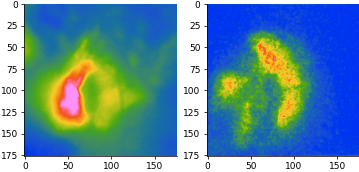

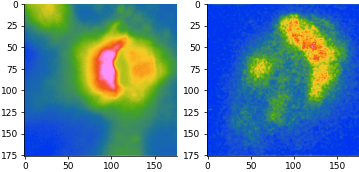

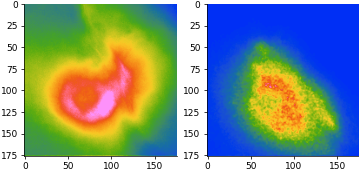

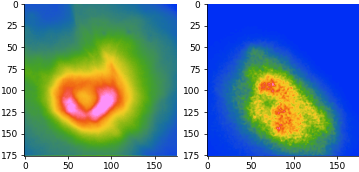

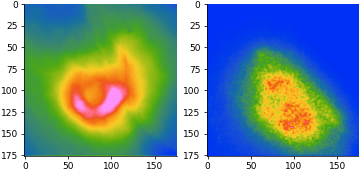

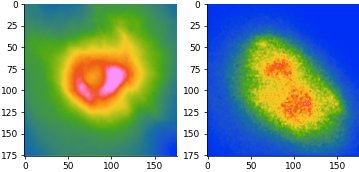

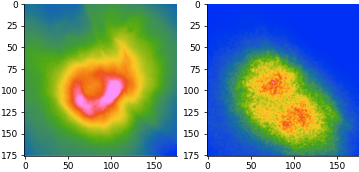

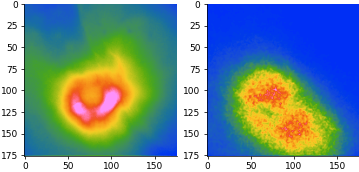

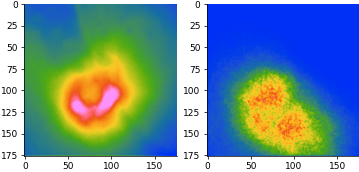

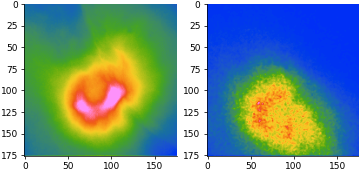

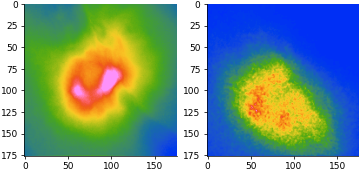

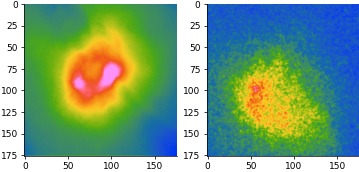

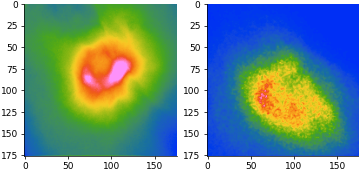

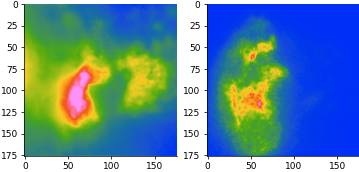

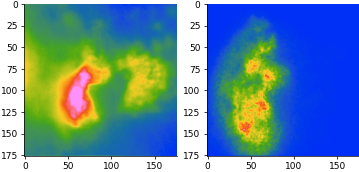

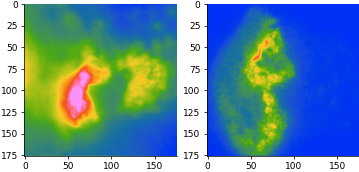

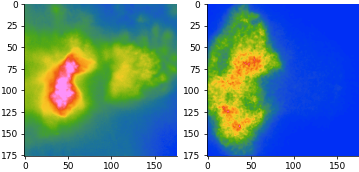

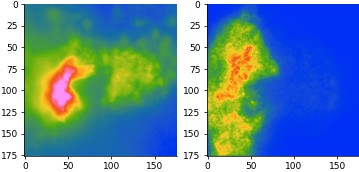

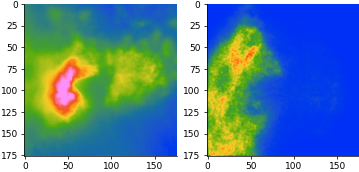

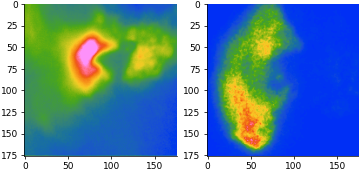

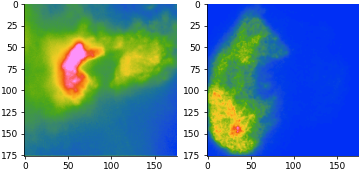

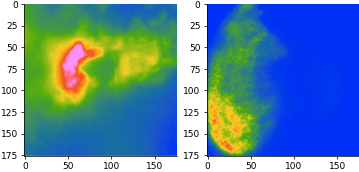

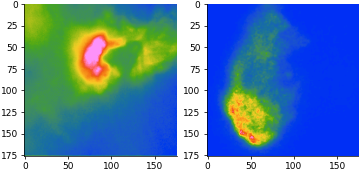

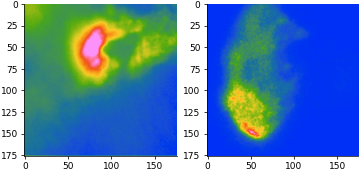

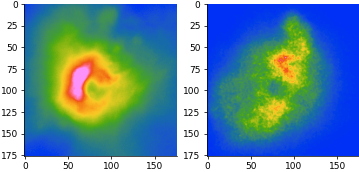

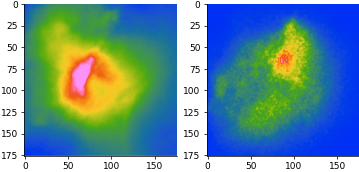

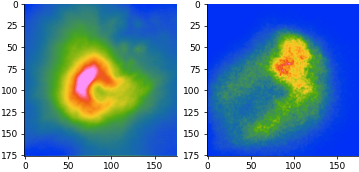

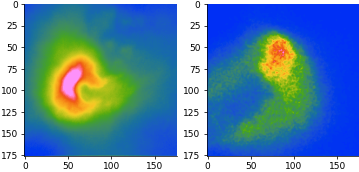

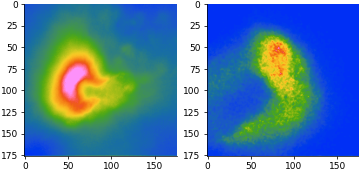

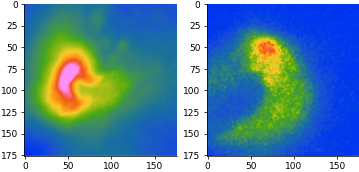

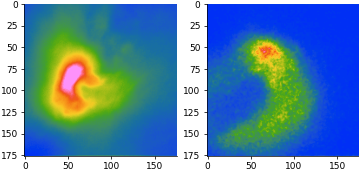

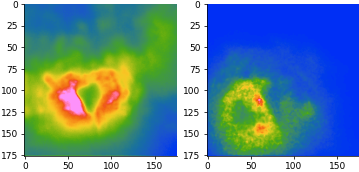

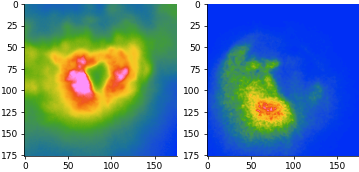

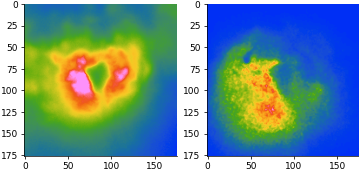

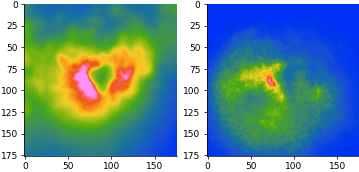

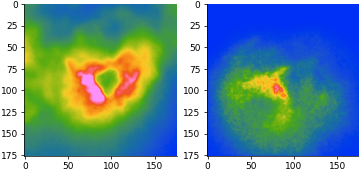

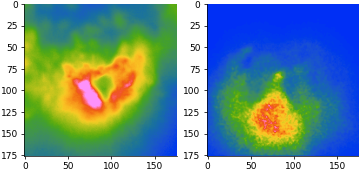

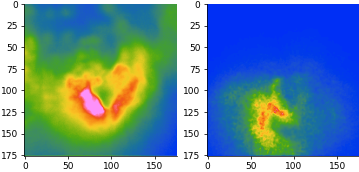

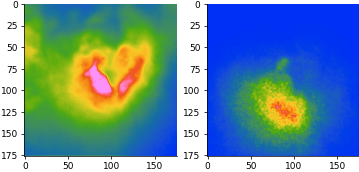

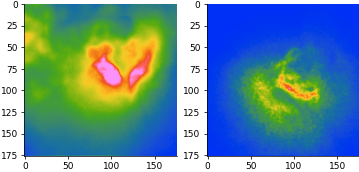

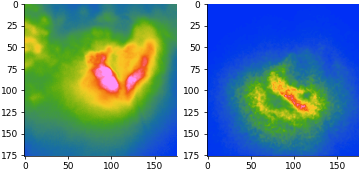

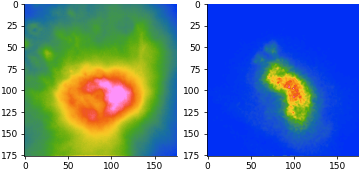

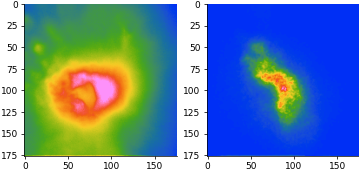

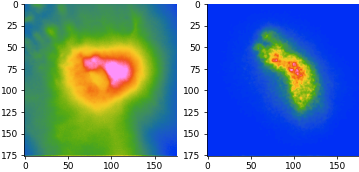

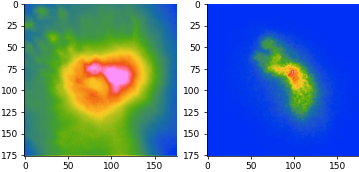

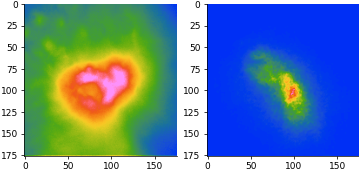

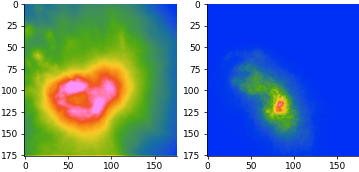

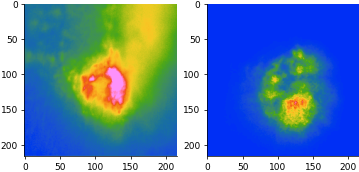

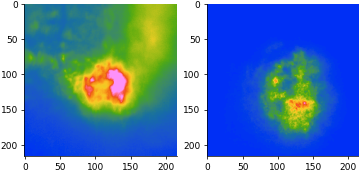

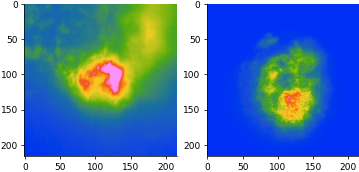

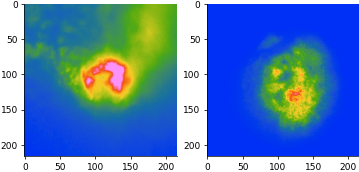

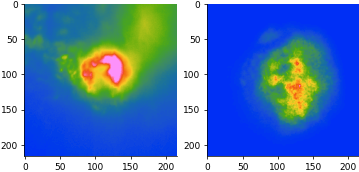

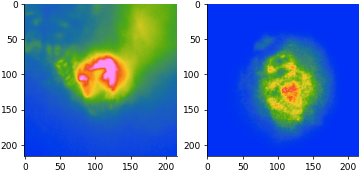

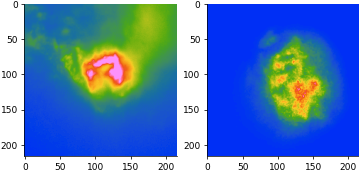

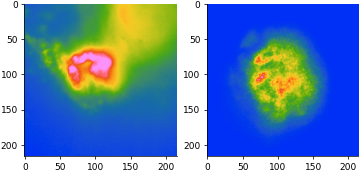

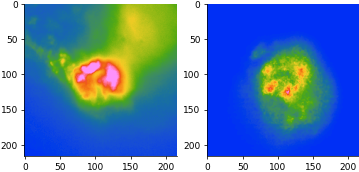

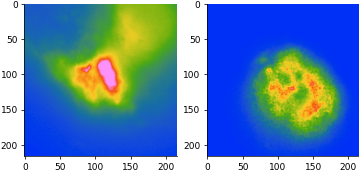

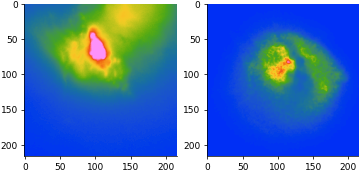

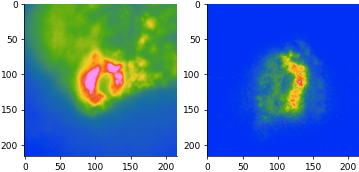

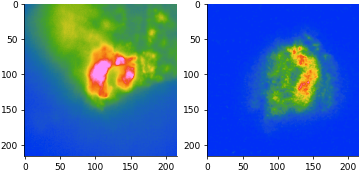

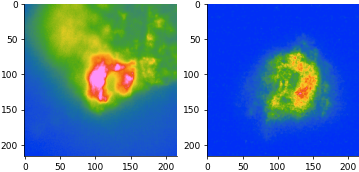

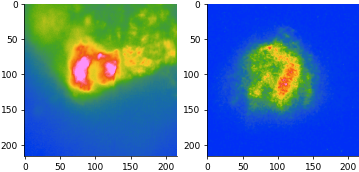

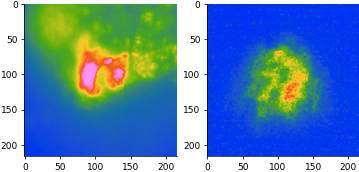

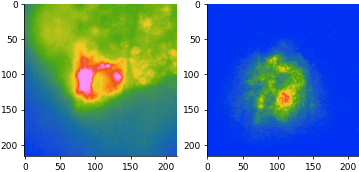

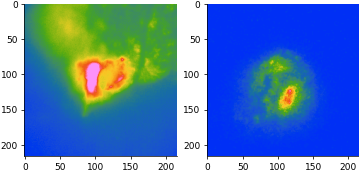

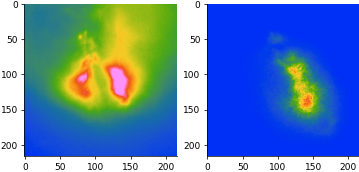

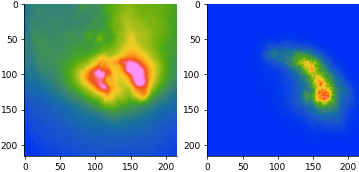

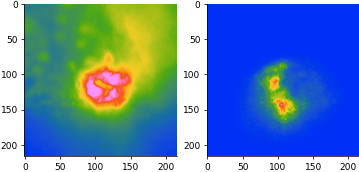

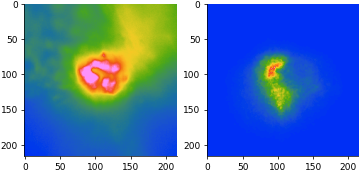

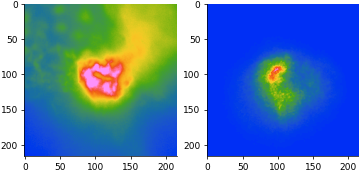

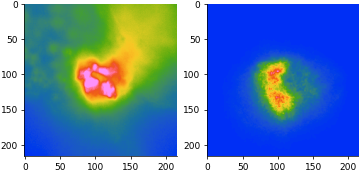

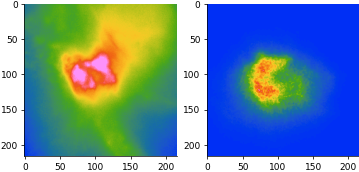

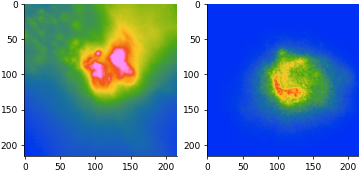

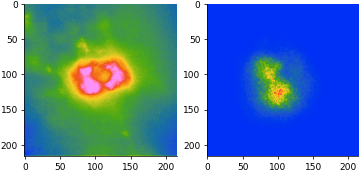

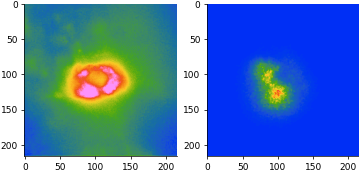

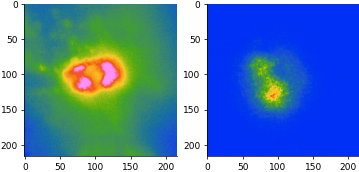

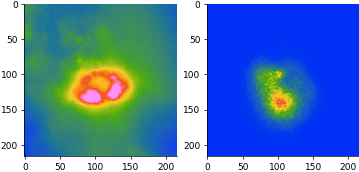

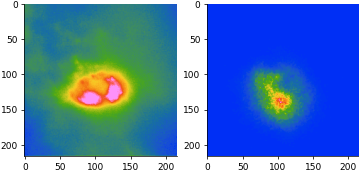

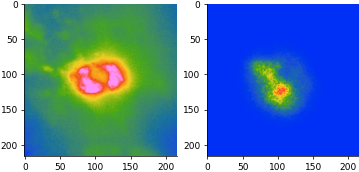

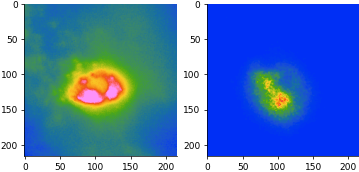

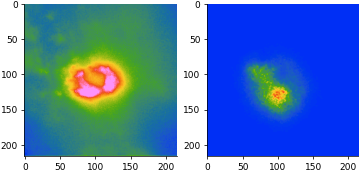

In [15]:
subfolder = "corrected"
nkx_vs_gcamp = []
for idx, row in waveprop_data.iterrows():
    datadir = remote_data_rootdir/"BU"/os.path.basename(row["expt_name"])
    try:
        snap_path = datadir/"Snaps"/row["snap_file"]
    except Exception as e:
        print(idx, row["snap_file"])
#             raise e
        continue
#     sta = skio.imread(datadir/"analysis"/subfolder/row["file_name"]/"sta.tif")
    beta = np.load(datadir/"analysis"/subfolder/f"{row['file_name']}_snapt.npz")["beta"]
    snr = np.nan_to_num((np.abs(beta[2] - 1)/beta[5])**2, nan=0)
    dff = np.nan_to_num(beta[2] - 1, nan=0)
    nkx = images.match_snap_to_data(skio.imread(snap_path), snr, scale_factor=4) - 100
    clamp = np.percentile(nkx, 99)
    nkx[nkx > clamp] = clamp
    nkx = exposure.rescale_intensity(nkx, out_range=(0,1))
    fig1, axs = plt.subplots(1,2, figsize=(6,3))
    axs[0].imshow(nkx)
    axs[1].imshow(snr)
    img_df = pd.DataFrame({
        "expt_name": [str(row["expt_name"])]*64,
        "file_name": [str(row["file_name"])]*64,
        "embryo": [row["embryo"]]*64,
        "est_tpo_h": [row["est_tpo_h"]]*64,
        "intensity_norm": transform.resize(nkx, (8,8)).ravel(),
        "snr": transform.resize(snr, (8,8)).ravel(),
        "dff": transform.resize(dff, (8,8)).ravel(),
        "cond": ["nkx"]*64

    })
    nkx_vs_gcamp.append(img_df)

In [16]:
nkx_gcamp_df = pd.concat(nkx_vs_gcamp, axis=0)

In [19]:
nkx_gcamp_df.reset_index().to_csv(output_datadir/"nkx_intensity_vs_snr.csv", index=False)

In [18]:
nkx_gcamp_df["snr_db"] = 10*np.log10(nkx_gcamp_df["snr"])

Text(0, 0.5, 'jGCaMP7f $\\mathrm{SNR^2}$ (dB)')

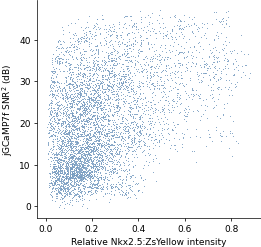

In [14]:
fig1, ax1 = plt.subplots(figsize=(4,4))
sns.scatterplot(data=nkx_gcamp_df, x="intensity_norm", y="snr_db", s=1)
ax1.set_xlabel("Relative Nkx2.5:ZsYellow intensity")
ax1.set_ylabel(r"jGCaMP7f $\mathrm{SNR^2}$ (dB)")